In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
from typing import Dict, Any
from itertools import product
from collections import Counter
from tqdm import tqdm
from scipy.stats import chi2_contingency
from statsmodels.sandbox.stats.runs import runstest_1samp
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.interpolate import interp1d
from scipy.stats import  gaussian_kde
from scipy.stats import ks_2samp

In [6]:
apple = pd.read_csv(r"D:\data\notebooks\week-10\cleaned_apple_high_low.csv")
apple['DATE'] = pd.to_datetime(apple['DATE'], errors='coerce')

apple.head()

,DATE,weekday,OPEN,CLOSE,VOL,HIGH,LOW
0,1984-09-07,Friday,0.10122,0.10122,97236149.0,0.10246,0.10000
1,1984-09-10,Monday,0.10122,0.10062,75471114.0,0.10153,0.09878
2,1984-09-11,Tuesday,0.10153,0.10246,177965367.0,0.10428,0.10153
3,1984-09-12,Wednesday,0.10246,0.09938,155467926.0,0.10306,0.09938
4,1984-09-13,Thursday,0.10490,0.10490,242135546.0,0.10520,0.10490


In [12]:

apple = apple.sort_values('DATE')
apple['MID'] = (apple['HIGH'] + apple['LOW']) / 2

# 2. Keep only Mondays
monday = apple[apple['DATE'].dt.weekday == 0].copy()
monday = monday.sort_values('DATE').reset_index(drop=True)
monday['t'] = np.arange(len(monday))  # time index (week number)

# 3. Define window sizes (past Mondays)
windows = [2, 4, 6, 8, 10, 20]

support_vals = np.full(len(monday), np.nan)
resistance_vals = np.full(len(monday), np.nan)

# 4. For each Monday, fit lines on past W Mondays and get support/resistance
for i in range(len(monday)):
    t_i = monday.loc[i, 't']
    candidates = []
    for W in windows:
        if i + 1 >= W:  # need at least W points
            start = i + 1 - W
            subset = monday.iloc[start:i+1]
            t = subset['t'].values
            y = subset['MID'].values
            # linear regression: y = m*t + b
            m, b = np.polyfit(t, y, 1)
            p_hat = m * t_i + b  # value of line at current Monday
            candidates.append(p_hat)
    if candidates:
        support_vals[i] = min(candidates)    # lowest line value -> support
        resistance_vals[i] = max(candidates) # highest line value -> resistance

monday['SUPPORT'] = support_vals
monday['RESISTANCE'] = resistance_vals

# 5. Plot last 5 years of Monday mid price + support/resistance curves
recent = monday[monday['DATE'] >= monday['DATE'].max() - pd.Timedelta(days=365*5)]



recent.head()


,DATE,weekday,OPEN,CLOSE,VOL,HIGH,LOW,MID,t,SUPPORT,RESISTANCE
1702,2017-04-24,Monday,33.871,33.903,72523556.0,33.978,33.794,33.8860,1702,33.674350,34.904714
1703,2017-05-01,Monday,34.248,34.600,142039827.0,34.750,34.217,34.4835,1703,34.227292,35.202171
1704,2017-05-08,Monday,35.177,36.116,206253772.0,36.278,35.177,35.7275,1704,34.850345,35.727500
1705,2017-05-15,Monday,36.978,36.902,109339614.0,37.129,36.750,36.9395,1705,35.790855,36.939500
1706,2017-05-22,Monday,36.498,36.496,96763782.0,36.635,36.240,36.4375,1706,36.331945,36.979381


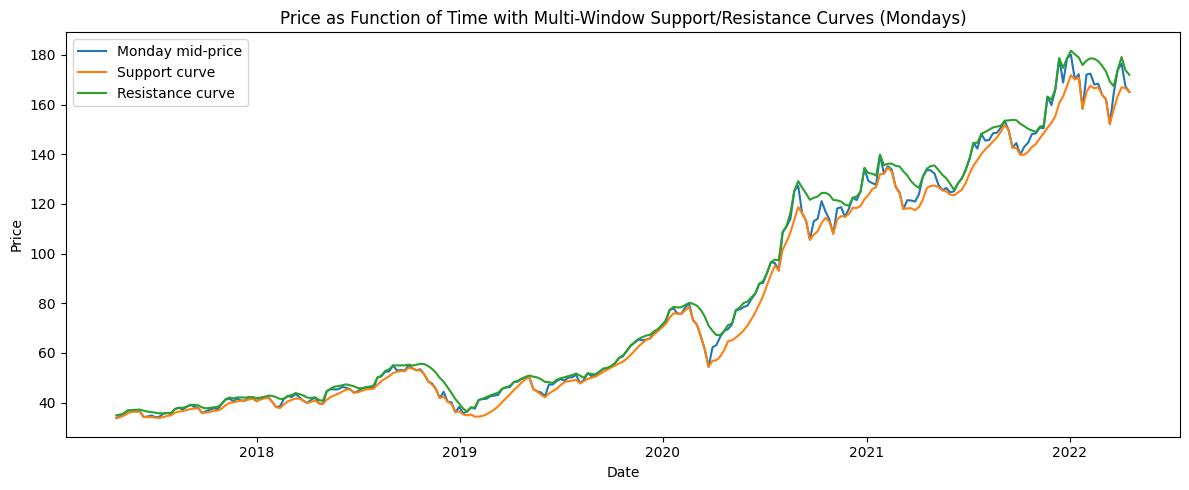

In [13]:
plt.figure(figsize=(12,5))
plt.plot(recent['DATE'], recent['MID'], label='Monday mid-price')
plt.plot(recent['DATE'], recent['SUPPORT'], label='Support curve')
plt.plot(recent['DATE'], recent['RESISTANCE'], label='Resistance curve')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price as Function of Time with Multi-Window Support/Resistance Curves (Mondays)")
plt.legend()
plt.tight_layout()

,DATE,weekday,OPEN,CLOSE,VOL,HIGH,LOW,MID,t,SUPPORT,RESISTANCE
1702,2017-04-24,Monday,33.871,33.903,72523556.0,33.978,33.794,33.8860,1702,33.720917,33.894089
1703,2017-05-01,Monday,34.248,34.600,142039827.0,34.750,34.217,34.4835,1703,34.140200,34.469917
1704,2017-05-08,Monday,35.177,36.116,206253772.0,36.278,35.177,35.7275,1704,35.032446,35.619750
1705,2017-05-15,Monday,36.978,36.902,109339614.0,37.129,36.750,36.9395,1705,36.094304,36.944833
1706,2017-05-22,Monday,36.498,36.496,96763782.0,36.635,36.240,36.4375,1706,36.723167,37.006600


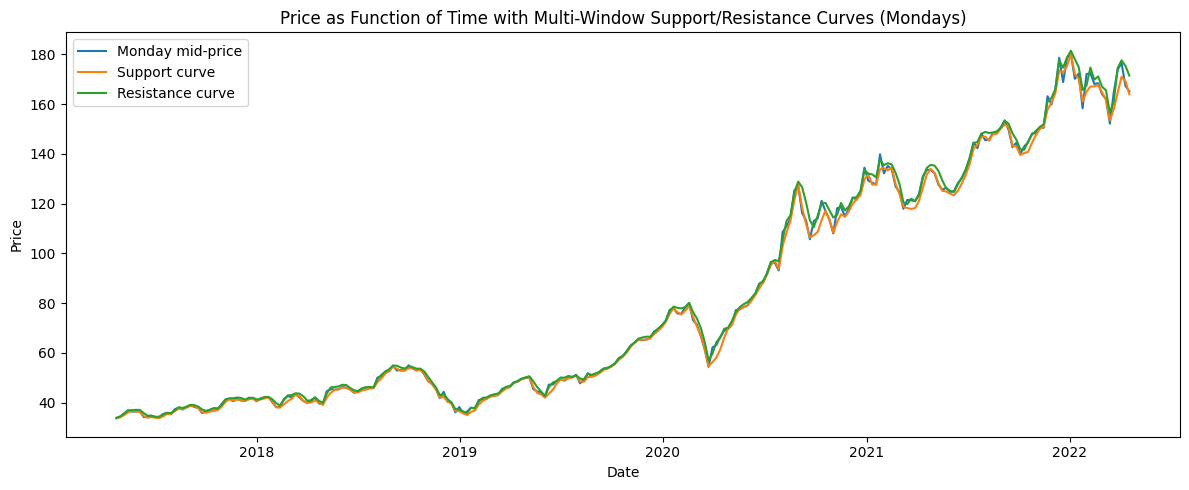

In [14]:

apple = apple.sort_values('DATE')
apple['MID'] = (apple['HIGH'] + apple['LOW']) / 2

# 2. Keep only Mondays
monday = apple[apple['DATE'].dt.weekday == 0].copy()
monday = monday.sort_values('DATE').reset_index(drop=True)
monday['t'] = np.arange(len(monday))  # time index (week number)

# 3. Define window sizes (past Mondays)
windows = [3, 5, 7]

support_vals = np.full(len(monday), np.nan)
resistance_vals = np.full(len(monday), np.nan)

# 4. For each Monday, fit lines on past W Mondays and get support/resistance
for i in range(len(monday)):
    t_i = monday.loc[i, 't']
    candidates = []
    for W in windows:
        if i + 1 >= W:  # need at least W points
            start = i + 1 - W
            subset = monday.iloc[start:i+1]
            t = subset['t'].values
            y = subset['MID'].values
            # linear regression: y = m*t + b
            m, b = np.polyfit(t, y, 1)
            p_hat = m * t_i + b  # value of line at current Monday
            candidates.append(p_hat)
    if candidates:
        support_vals[i] = min(candidates)    # lowest line value -> support
        resistance_vals[i] = max(candidates) # highest line value -> resistance

monday['SUPPORT'] = support_vals
monday['RESISTANCE'] = resistance_vals

# 5. Plot last 5 years of Monday mid price + support/resistance curves
recent = monday[monday['DATE'] >= monday['DATE'].max() - pd.Timedelta(days=365*5)]

plt.figure(figsize=(12,5))
plt.plot(recent['DATE'], recent['MID'], label='Monday mid-price')
plt.plot(recent['DATE'], recent['SUPPORT'], label='Support curve')
plt.plot(recent['DATE'], recent['RESISTANCE'], label='Resistance curve')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price as Function of Time with Multi-Window Support/Resistance Curves (Mondays)")
plt.legend()
plt.tight_layout()

recent.head()


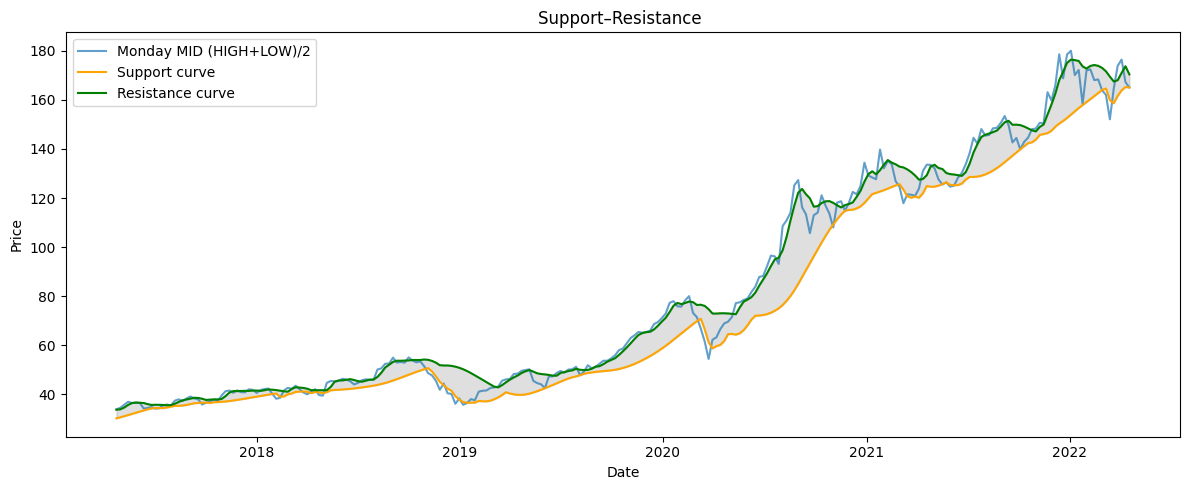

In [17]:

apple["DATE"] = pd.to_datetime(apple["DATE"])  # IMPORTANT
apple = apple.sort_values("DATE")

# -----------------------------------------
# 1. Daily midpoint using HIGH and LOW
# -----------------------------------------
apple["MID_HL"] = (apple["HIGH"] + apple["LOW"]) / 2

# -----------------------------------------
# 2. Keep only Mondays (weekly time grid)
# -----------------------------------------
monday = apple[apple["DATE"].dt.weekday == 0].copy()
monday = monday.sort_values("DATE").reset_index(drop=True)
monday["t"] = np.arange(len(monday))  # integer time index

# -----------------------------------------
# 3. Define window sizes (in Mondays)
# -----------------------------------------
windows = [3, 5, 10, 20]

# -----------------------------------------
# 4. For each W, create a smoothed Monday series
#    Smooth_W(t) = average of last W Monday MID_HL values
# -----------------------------------------
for W in windows:
    monday[f"SMOOTH_{W}"] = monday["MID_HL"].rolling(window=W, min_periods=W).mean()

# -----------------------------------------
# 5. For EACH Monday, fit regression per window,
#    then take min/max of predictions => support/resistance
# -----------------------------------------
support = np.full(len(monday), np.nan)
resistance = np.full(len(monday), np.nan)

for i in range(len(monday)):
    t_i = monday.loc[i, "t"]  # time of "today's" Monday
    preds = []

    for W in windows:
        col = f"SMOOTH_{W}"
        # use smoothed data up to today
        valid = monday.loc[:i, ["t", col]].dropna()
        # need at least 2 points to fit a line
        if len(valid) >= 2:
            # use at most the last W smoothed points
            subset = valid.tail(W)
            t_vals = subset["t"].values
            y_vals = subset[col].values

            # fit y = m*t + b
            m, b = np.polyfit(t_vals, y_vals, 1)
            p_hat = m * t_i + b     # prediction for today at this window
            preds.append(p_hat)

    # combine predictions from all windows
    if preds:
        support[i] = min(preds)
        resistance[i] = max(preds)

monday["SUPPORT"] = support
monday["RESISTANCE"] = resistance

# -----------------------------------------
# 6. Plot: Monday mid price + support/resistance curves
#    (show last 5 years for readability)
# -----------------------------------------
recent_mask = monday["DATE"] >= monday["DATE"].max() - pd.Timedelta(days=365*5)
recent = monday[recent_mask]

plt.figure(figsize=(12, 5))
plt.plot(recent["DATE"], recent["MID_HL"], label="Monday MID (HIGH+LOW)/2", alpha=0.7)
plt.plot(recent["DATE"], recent["SUPPORT"], label="Support curve", linewidth=1.5, color="orange")
plt.plot(recent["DATE"], recent["RESISTANCE"], label="Resistance curve", linewidth=1.5, color="green")

# Shade area between support and resistance
plt.fill_between(
    recent["DATE"],
    recent["SUPPORT"],
    recent["RESISTANCE"],
    color="gray",
    alpha=0.25
)

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Support–Resistance ")
plt.legend()
plt.tight_layout()
plt.show()

